## Decision Trees (CART, Gini) — End-to-End Workflow

This notebook walks through a complete supervised learning pipeline for Decision Trees:
	•	Data Exploration: load, inspect, visualize
	•	Preprocessing: splits, (optional) imputation
	•	Modeling: from-scratch CART implementation and scikit-learn baseline, plus tuning
	•	Evaluation: accuracy, confusion matrix, classification report, ROC-AUC, feature importances, decision regions


## Setup

We’ll use the Iris dataset (multiclass) to keep plots interpretable. Decision Trees don’t require feature scaling; we include imputation in pipelines for generality.

In [ ]:
# Install required packages into THIS kernel (safe to run multiple times)
import sys, subprocess, importlib

def ensure(pkg_import, pip_name=None):
    pip_name = pip_name or pkg_import
    try:
        importlib.import_module(pkg_import)
        print(f"{pip_name} already installed.")
    except Exception:
        print(f"Installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

# Core deps
ensure("pandas")
ensure("sklearn", "scikit-learn")
ensure("matplotlib")
ensure("seaborn")

pandas already installed.
scikit-learn already installed.
matplotlib already installed.
seaborn already installed.


In [81]:
# Imports and seed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Optional, Tuple
from IPython.display import display

# sklearn utilities
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Optional visualization helper
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)

## Data Exploration

We’ll load the Iris dataset, inspect structure and class balance, and (optionally) view pairwise relationships.

In [82]:
# Load data into a DataFrame

iris = load_iris(as_frame=True)
X: pd.DataFrame = iris.data.copy()
y: pd.Series = iris.target.copy()  # 0=setosa, 1=versicolor, 2=virginica

df = X.copy()
df['target'] = y

print('Shape:' , df.shape)
display(df.head())
display(df.describe(include='all'))

print('\n Class counts:')
class_counts = df['target'].value_counts().rename(index=dict(enumerate(iris.target_names)))
display(class_counts)

Shape: (150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000



 Class counts:


target
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

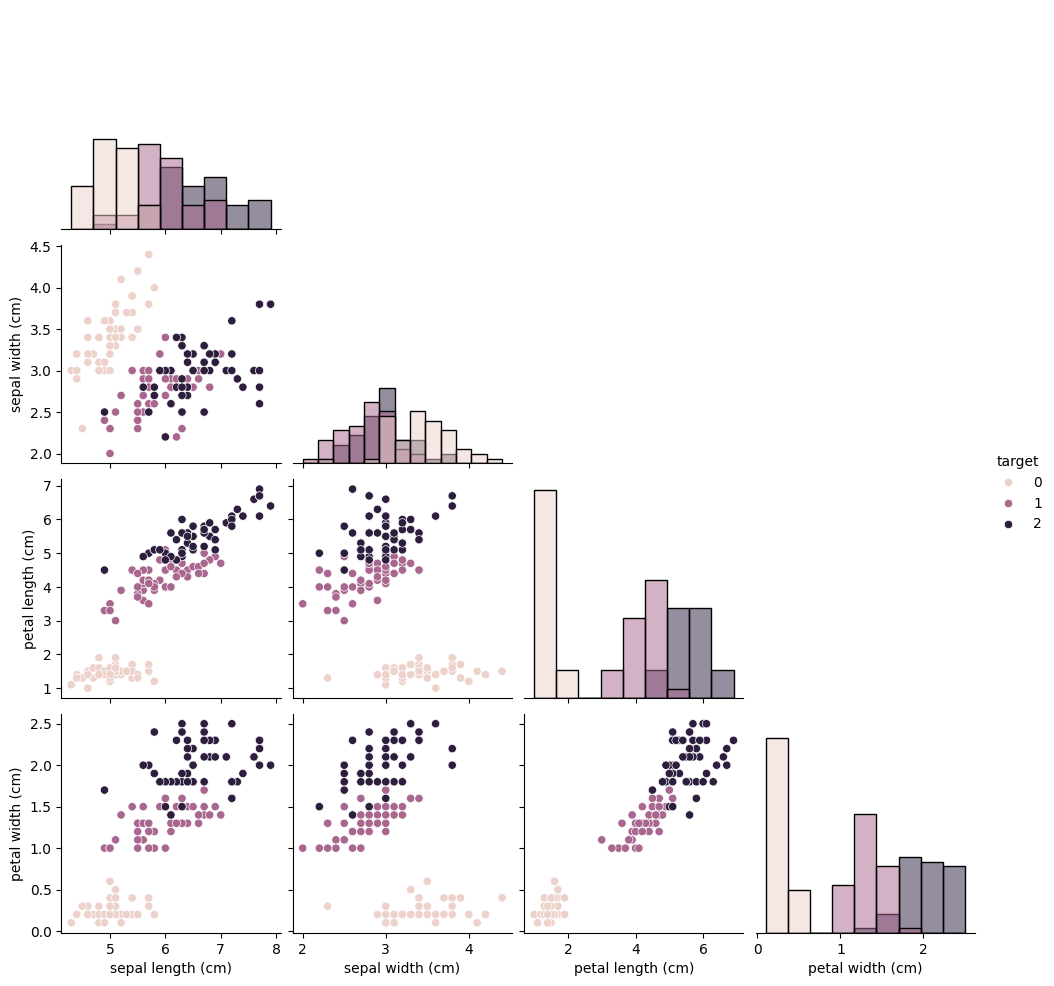

In [83]:
if sns is not None:
    try:
        sns.pairplot(df, hue='target', corner=True, diag_kind='hist')
        plt.show()
    except Exception as e:
        print('Skipping pairplot:', e)
else:
    print('Seaborn not installed; skipping pairplot.')

## Preprocessing
	•	Stratified train/test split to preserve class proportions
	•	Imputation is included in pipelines for robustness (Iris has no missing values)

In [84]:
## Train/Test split

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, stratify=y, random_state=42
)
print('Train shape:', X_train.shape, ' Test shape:', X_test.shape)

Train shape: (112, 4)  Test shape: (38, 4)


## Modeling

We’ll implement two models:
	1.	From-scratch CART classifier (Gini impurity, binary splits) — for learning
	2.	scikit-learn DecisionTreeClassifier — production-grade baseline

We’ll also show simple hyperparameter tuning with GridSearchCV.

In [85]:
from dataclasses import dataclass
from typing import Optional, Tuple, Union
import numpy as np
import pandas as pd

@dataclass
class _Node:
    gini: float
    num_samples: int
    num_samples_per_class: np.ndarray
    predicted_class: int
    feature_index: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional["_Node"] = None
    right: Optional["_Node"] = None

class SimpleDecisionTreeClassifier:
    """
    A minimal CART-style Decision Tree Classifier using Gini impurity.
    Supports multiclass. Designed for clarity over speed.
    """
    def __init__(
        self,
        max_depth: Optional[int] = None,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
    ):
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.n_classes_: Optional[int] = None
        self.n_features_: Optional[int] = None
        self.tree_: Optional[_Node] = None

    def fit(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        y: Union[pd.Series, np.ndarray]
    ):
        X = np.asarray(X)
        y = np.asarray(y, dtype=int)
        self.n_classes_ = int(np.max(y)) + 1
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y, depth=0)
        return self

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X)
        return np.array([self._predict_row(row) for row in X], dtype=int)

    def predict_proba(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X)
        probs = []
        for row in X:
            node = self._traverse(row)
            counts = node.num_samples_per_class.astype(float)
            probs.append(counts / counts.sum())
        return np.vstack(probs)

    # ---- internals ----
    def _gini(self, y: np.ndarray) -> float:
        m = y.size
        if m == 0:
            return 0.0
        counts = np.bincount(y, minlength=self.n_classes_)
        p = counts / m
        return 1.0 - np.sum(p ** 2)

    def _best_split(
        self, X: np.ndarray, y: np.ndarray
    ) -> Tuple[Optional[int], Optional[float]]:
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None

        for idx in range(n):
            order = np.argsort(X[:, idx])
            thresholds = X[order, idx]
            classes = y[order]

            num_left = np.zeros(self.n_classes_, dtype=int)
            num_right = np.bincount(classes, minlength=self.n_classes_)

            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1

                # skip identical thresholds
                if thresholds[i] == thresholds[i - 1]:
                    continue

                left_count = i
                right_count = m - i
                if (
                    left_count < self.min_samples_leaf
                    or right_count < self.min_samples_leaf
                ):
                    continue

                gini_left = 1.0 - np.sum((num_left / left_count) ** 2)
                gini_right = 1.0 - np.sum((num_right / right_count) ** 2)
                gini = (left_count * gini_left + right_count * gini_right) / m

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = 0.5 * (thresholds[i] + thresholds[i - 1])

        return best_idx, best_thr

    def _grow_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> _Node:
        num_samples_per_class = np.bincount(y, minlength=self.n_classes_)
        predicted_class = int(np.argmax(num_samples_per_class))
        node = _Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        depth_ok = True if self.max_depth is None else (depth < self.max_depth)
        if depth_ok:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                left_mask = X[:, idx] < float(thr)
                X_left, y_left = X[left_mask], y[left_mask]
                X_right, y_right = X[~left_mask], y[~left_mask]

                if y_left.size and y_right.size:
                    node.feature_index = idx
                    node.threshold = float(thr)
                    node.left = self._grow_tree(X_left, y_left, depth + 1)
                    node.right = self._grow_tree(X_right, y_right, depth + 1)

        return node

    def _traverse(self, row: np.ndarray) -> _Node:
        node = self.tree_
        while node and node.left is not None:
            if row[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node

    def _predict_row(self, row: np.ndarray) -> int:
        node = self._traverse(row)
        return node.predicted_class

In [86]:
## scikit-learn baseline pipeline (imputer + tree)

sk_tree_clf = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('tree', DecisionTreeClassifier(random_state=42, max_depth=3))
])

## Fit both models

simple_tree = SimpleDecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1)
simple_tree.fit(X_train, y_train)

sk_tree_clf.fit(X_train, y_train)

,steps,"[('imputer', ...), ('tree', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,criterion,'gini'


## Hyperparameter Tuning (sklearn)

We’ll sweep criterion, max_depth, and min_samples_leaf with GridSearchCV.

In [87]:
param_grid = {
'tree__criterion': ['gini', 'entropy', 'log_loss'],
'tree__max_depth': [None, 2, 3, 4, 5],
'tree__min_samples_leaf': [1, 2, 3, 4],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
estimator=Pipeline([
('imputer', SimpleImputer(strategy='median')),
('tree', DecisionTreeClassifier(random_state=42))
]),
param_grid=param_grid,
scoring='accuracy',
cv=cv,
n_jobs=-1
)

grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
print('Best CV accuracy:', grid.best_score_)

best_model = grid.best_estimator_

Best params: {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_leaf': 1}
Best CV accuracy: 0.9553359683794467


## Evaluation

We’ll compute accuracy, confusion matrices, classification reports, and macro ROC-AUC (OvR).
We’ll also inspect the sklearn tree’s feature importances and text view.
Finally, we’ll visualize decision regions using 2 features for intuition.

In [88]:
## Predictions & metrics (from-scratch)

y_pred_simple = simple_tree.predict(X_test)
acc_simple = accuracy_score(y_test, y_pred_simple)
print(f'From-scratch tree accuracy: {acc_simple:.3f}')

print('\nConfusion matrix (from-scratch):')
print(confusion_matrix(y_test, y_pred_simple))

print('\nClassification report (from-scratch):')
print(classification_report(y_test, y_pred_simple, target_names=iris.target_names))

## Macro ROC-AUC (OvR) for multiclass

proba_simple = simple_tree.predict_proba(X_test)
try:
    auc_simple = roc_auc_score(y_test, proba_simple, multi_class='ovr', average='macro')
    print(f'Macro ROC-AUC (from-scratch): {auc_simple:.3f}')
except Exception as e:
    print('ROC-AUC skipped:', e)

From-scratch tree accuracy: 0.921

Confusion matrix (from-scratch):
[[12  0  0]
 [ 0 13  0]
 [ 0  3 10]]

Classification report (from-scratch):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.81      1.00      0.90        13
   virginica       1.00      0.77      0.87        13

    accuracy                           0.92        38
   macro avg       0.94      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38

Macro ROC-AUC (from-scratch): 0.997


In [89]:
## Predictions & metrics (sklearn baseline)

y_pred_sk = sk_tree_clf.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk)
print(f'sklearn DecisionTree accuracy: {acc_sk:.3f}')

print('\nConfusion matrix (sklearn):')
print(confusion_matrix(y_test, y_pred_sk))

print('\nClassification report (sklearn):')
print(classification_report(y_test, y_pred_sk, target_names=iris.target_names))

proba_sk = sk_tree_clf.predict_proba(X_test)
auc_sk = roc_auc_score(y_test, proba_sk, multi_class='ovr', average='macro')
print(f'Macro ROC-AUC (sklearn): {auc_sk:.3f}')

sklearn DecisionTree accuracy: 0.895

Confusion matrix (sklearn):
[[12  0  0]
 [ 0 12  1]
 [ 0  3 10]]

Classification report (sklearn):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.80      0.92      0.86        13
   virginica       0.91      0.77      0.83        13

    accuracy                           0.89        38
   macro avg       0.90      0.90      0.90        38
weighted avg       0.90      0.89      0.89        38

Macro ROC-AUC (sklearn): 0.977



Textual tree:

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.85
|   |   |--- petal width (cm) <= 1.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.65
|   |   |   |--- class: 1
|   |--- petal length (cm) >  4.85
|   |   |--- petal width (cm) <= 1.70
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.70
|   |   |   |--- class: 2



,feature,importance
2,petal length (cm),0.950732
3,petal width (cm),0.049268
0,sepal length (cm),0.000000
1,sepal width (cm),0.000000


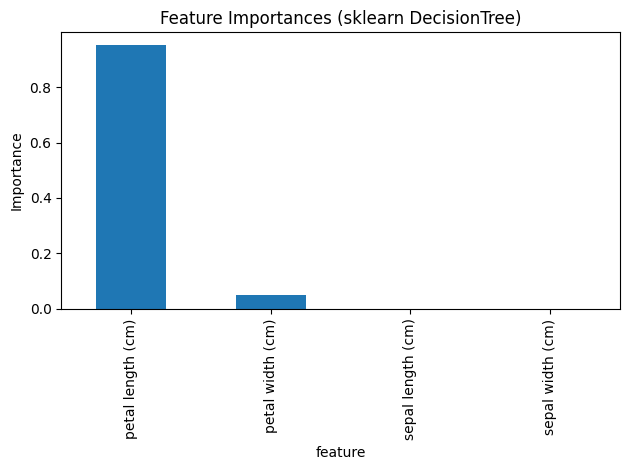

In [90]:
## Feature importances & tree text (sklearn)

inner_tree: DecisionTreeClassifier = sk_tree_clf.named_steps['tree']

print('\nTextual tree:\n')
print(export_text(inner_tree, feature_names=list(X.columns)))

importances = inner_tree.feature_importances_
imp_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)
display(imp_df)

plt.figure()
imp_df.set_index('feature')['importance'].plot(kind='bar')
plt.title('Feature Importances (sklearn DecisionTree)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Key Takeaways
	•	Greedy splitting chooses feature/threshold to reduce impurity (e.g., Gini).
	•	Regularize trees with max_depth, min_samples_leaf, min_samples_split, or pruning (ccp_alpha).
	•	Strengths: interpretability, handles nonlinearity, minimal preprocessing.
	•	Weaknesses: prone to overfitting; unstable to small perturbations.
	•	Next: try pruning curves, cross-dataset validation, and ensembles (RandomForest/GBDT).